<div>
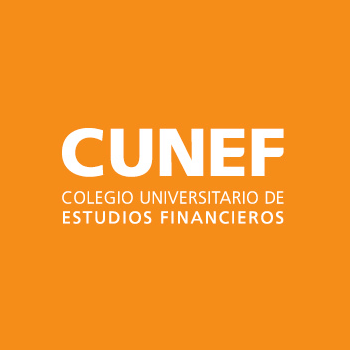
</div>


# **Desempleo en España**

En este notebook se mostrará la serie temporal de la **tasa de paro en España** y observaremos cómo afectó ésta frente al COVID-19. 

La tasa de paro expresa la proporción de parados que hay respecto al total de población activa. Tenemos que tener en cuenta que el desempleado es aquel trabajador que <u> no tiene empleo y que lo busca de forma activa</u>.


Estructura del notebook:
    
    1) Librerías utilizadas
    2) Lectura y preprocesado de los datos
    3) EDA (Análisis Exploratorio de Datos)
    4) Elección del modelo predictivo
        4.1) Modelo de suavizado exponencial (ETS)
        4.2) Modelo autorregresivo integrado de media móvil (ARIMA)
        4.3) Modelo FB Prophet
    5) Predicción hasta finales de año 

## *1) Librerías utilizadas*

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *2) Lectura y preprocesado de los datos*
Se procede a leer el archivo Excel de la tasa de desempleo español en total y en sectores.

- Fuente: https://www.sepe.es/HomeSepe/que-es-el-sepe/estadisticas/datos-avance/paro.html

In [61]:
df_paro=pd.read_excel("evolparoseries2.xls",index_col=0)
df_paro.tail()

,mes,total,agricultura,industria,construccion,servicios,sin_empleo_ant
NaN,202203,3108763,156354,254532,249107,2192580,256190
NaN,202204,3022503,146810,250192,242135,2127158,256208
NaN,202205,2922991,138117,242224,232127,2062928,247595
NaN,202206,2880582,146980,235076,227146,2021911,249469
NaN,202207,2883812,147805,233167,228122,2033148,241570


Para hacer efectivos los plots y sus análisis posteriores, cambiamos el formato de la fecha con la funcionalidad que nos ofrece la librería Pandas y lo indexamos. Además, como queremos analizar el desempleo en total, obviaremos los datos de desempleo en el resto de sectores.

In [62]:
df_paro.mes=pd.to_datetime(df_paro.mes,format='%Y%m')

df_paro=df_paro.set_index("mes")
df_paro=df_paro.iloc[:,0:1]
df_paro

,total
mes,
2013-01-01,4980778
2013-02-01,5040222
2013-03-01,5035243
2013-04-01,4989193
2013-05-01,4890928
...,...
2022-03-01,3108763
2022-04-01,3022503
2022-05-01,2922991


Chequeamos posibles valores faltantes en 'total', en el caso de que los haya los rellenaríamos aplicando una media o bien aplicando el dato del mes anterior. 

In [63]:
df_paro.isnull().sum()

total    0
dtype: int64

No hay errores en los periodos observados, por lo que vamos a proceder a la realización del análisis exploratorio mediante gráficos y cálculos estadísticos.

## *3) EDA*
Para realizar los plots, recurriremos a los que nos ofrece la librería Seaborn:



Text(0.5, 0, 'Periodo')

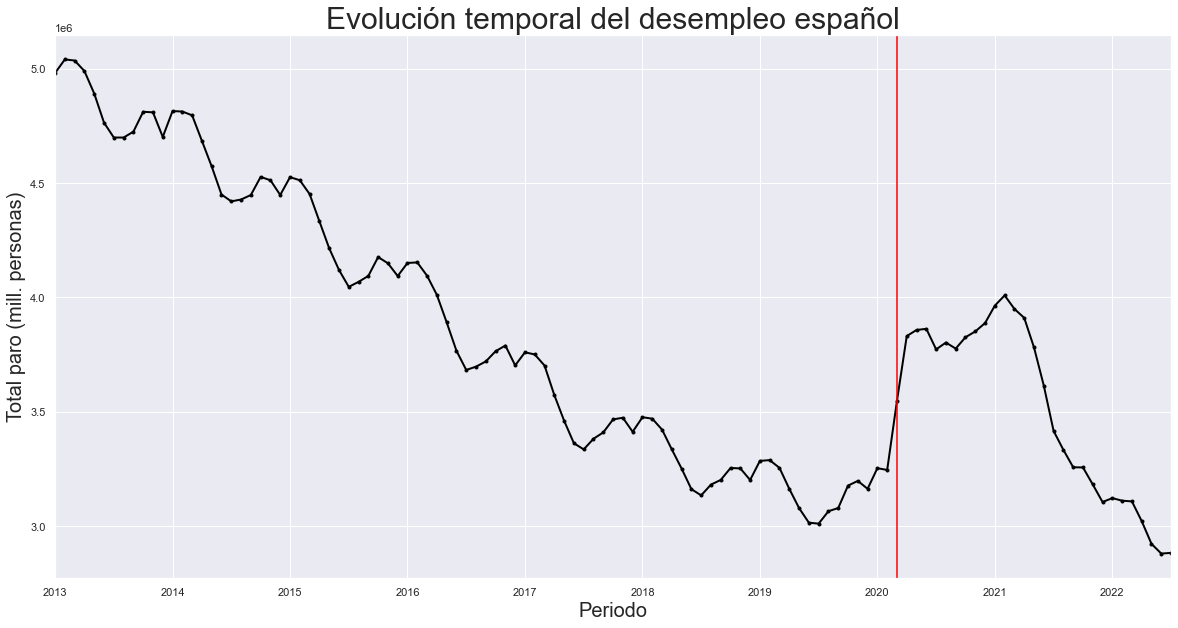

In [64]:
sns.set(rc={'figure.figsize':(20,10)})
fig=df_paro.total.plot(marker='.',color ='black',linewidth= 2)
fig.set_title('Evolución temporal del desempleo español',fontsize=30)
fig.set_ylabel('Total paro (mill. personas)',fontsize=20)
fig.axvline('2020-03-01',color='red',linewidth=1.5)
fig.set_xlabel('Periodo',fontsize=20)
# fig.figure.savefig('../pics/df_paro/tendencia.png')

Lo primero que nos llama la atención del DataFrame es que la serie temporal sigue una tendencia decreciente (creación de empleo) hasta marzo del 2020, momento en el que comienzan las restricciones por COVID-19. Muchos de esos empleados fueron despedidos y otros pasados por ERTEs debido a este fenómeno anormal, y se ha ido prolongando hasta aproximadamente enero-febrero del 2021, momento en el que vuelve a haber una tendencia decreciente. Se puede apreciar además que antes del COVID-19 había una estacionalidad, encontrándonos mínimos en las épocas de verano.


A continuación, analizaremos la estacionalidad y comprobaremos si la serie temporal es estacionaria mediante:
- Cálculo de la media y de la varianza
- Test de Dickey-Fuller aumentada
- Gráficas de comportamiento mensual
- Descomposición

Para que no nos afecte al análisis la situación anómala provocada por COVID-19, **analizaremos sólamente hasta el último mes antes del inicio de la pandemia**, esto es, **el mes de febrero del 2020**.

In [65]:
df_paro_eda=df_paro.iloc[:86,:]
df_paro_eda

,total
mes,
2013-01-01,4980778
2013-02-01,5040222
2013-03-01,5035243
2013-04-01,4989193
2013-05-01,4890928
...,...
2019-10-01,3177659
2019-11-01,3198184
2019-12-01,3163605


### 3.1) Cálculo de la media y de la varianza

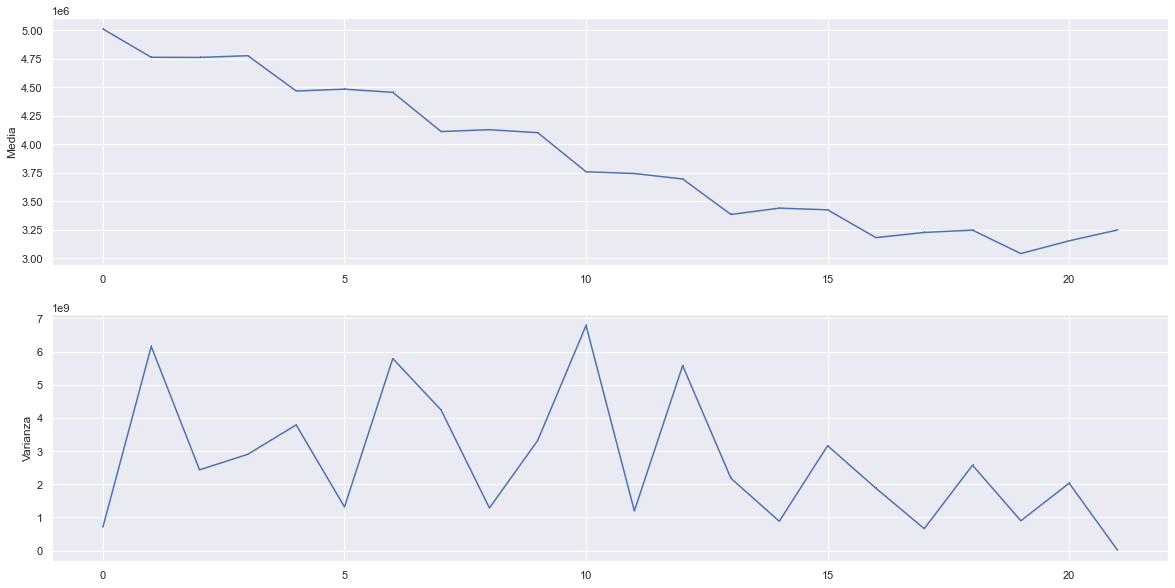

In [66]:
def split_and_summarize(dataframe,column,size,fn):
    ranges=[]
    values=[]
    for i in range(0,len(dataframe),size):
        ranges.append(dataframe[i:i+size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)
media=split_and_summarize(df_paro_eda,'total',4,np.mean)
varianza=split_and_summarize(df_paro_eda,'total',4,np.var)

# representación gráfica

cols=['media','varianza']
df=pd.DataFrame([media,varianza],index=cols)

sns.set(rc={'figure.figsize':(20,10)})
fig,(ax1,ax2)=plt.subplots(2,1)

ax1.plot(media,',-')
ax1.set_ylabel('Media')
ax2.plot(varianza,',-')
ax2.set_ylabel('Varianza')

# fig.figure.savefig('../pics/df_paro/meanvariance.png')
plt.show()

A simple vista se ve que la media no tiene unos valores constantes en el tiempo, lo que nos indica que la serie no es estacionaria, pero en varianza no se aprecia bien. Para asegurarnos al 100%, realizaremos la prueba de Dickey-Fuller aumentada.


### 3.2. Test de Dickey-Fuller aumentada

Esta prueba nos proporciona una verificación rápida y evidente de si la serie es estacionaria o no.

**La hipótesis nula (H0)** de la prueba es que la serie temporal se puede representar mediante una raíz unitaria, que no es estacionaria, es decir, que tiene alguna estructura dependiente del tiempo. 

**La hipótesis alternativa (H1)**, que rechaza la hipótesis nula, indica que la serie temporal es estacionaria.

Interpretamos este resultado utilizando el p-value. Un valor p por debajo del umbral de significancia (0.05) significa que la hipótesis nula se rechaza.

In [9]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_paro_eda.total)

Results of Dickey-Fuller Test:
Test Statistic                 -3.493219
p-value                         0.008163
#Lags Used                     12.000000
Number of Observations Used    73.000000
Critical Value (1%)            -3.523284
Critical Value (5%)            -2.902031
Critical Value (10%)           -2.588371
dtype: float64


**La serie temporal SÍ es estacionaria**, debido a que el p-value del test Dickey-Fuller (0.008) es menor que 0.05, y eso indica que se acepta la hipótesis nula (H0).

Además, vemos que nuestro test estadístico (-1.834) es bastante mayor que los umbrales de significancia del 1%, 5% y 10%, lo que nos da más indicios de que es una serie que posee alguna estructura dependiente del tiempo.

### 3.3) Gráficas de comportamiento mensual

A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

Text(0.5, 1.0, 'Comportamiento mensual')

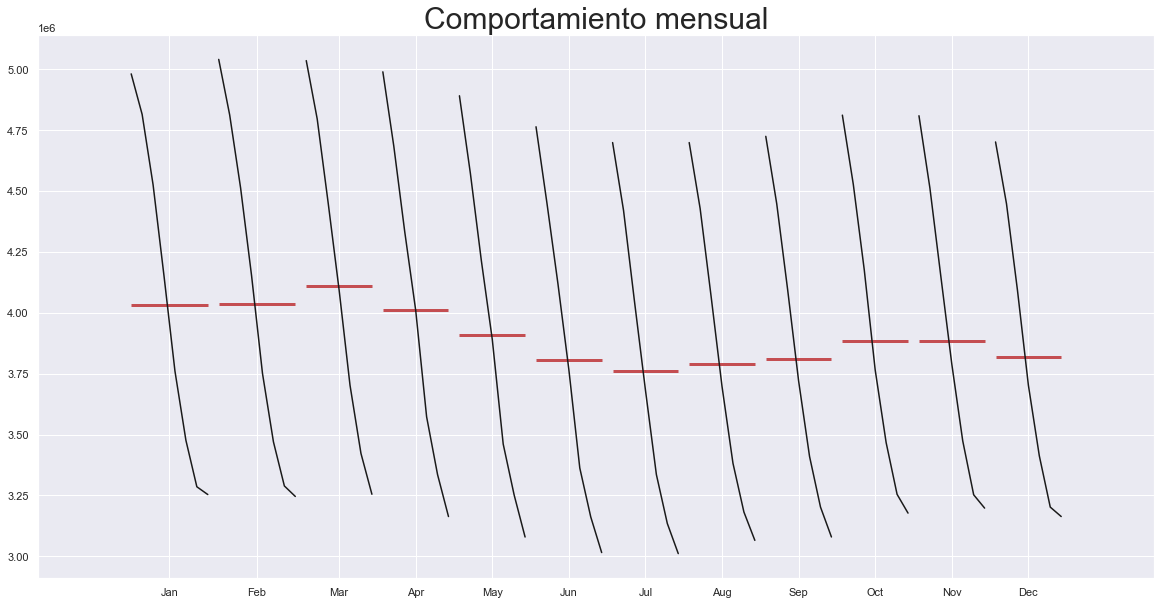

In [10]:
# Componente estacional mensual:
ax=plt.gca() 
sm.graphics.tsa.month_plot(df_paro_eda.total,ax=ax)
ax.set_title('Comportamiento mensual',fontsize=30)
# fig.figure.savefig('../pics/df_paro/monthlybehavior.png');

Pasamos a realizar un boxplot mensual para estudiar las distribuciones:

Text(0.5, 1.0, 'Comportamiento mensual')

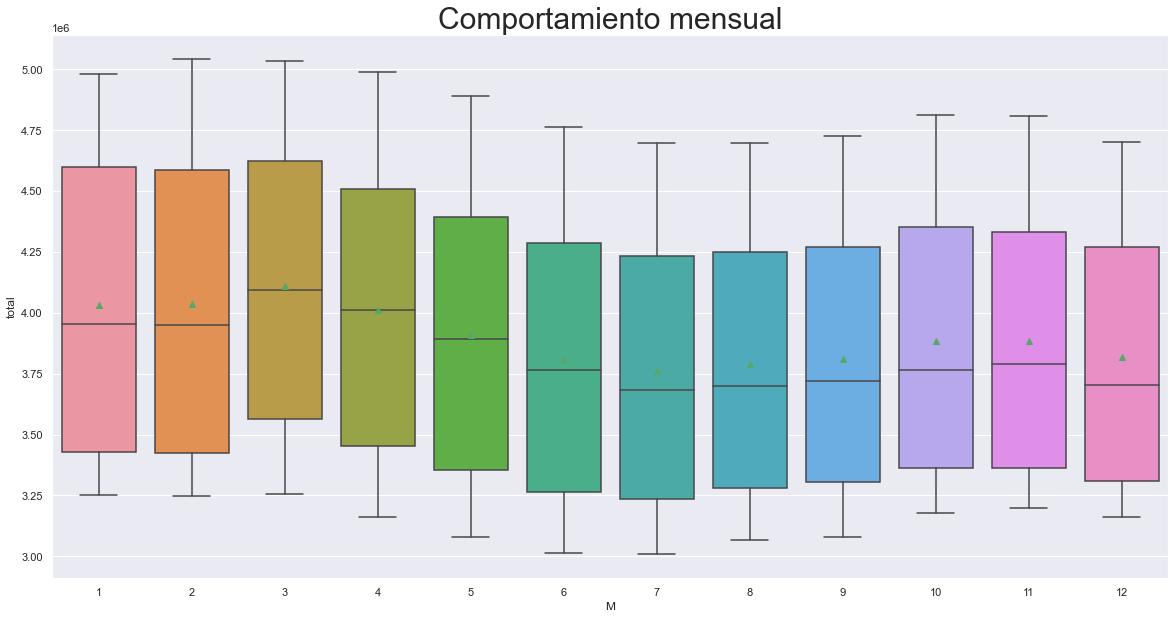

In [11]:
df_paro_eda['M']=df_paro_eda.index.month
sns.boxplot(data=df_paro_eda,x='M',y='total',showmeans=True)
ax=plt.gca()
ax.set_title('Comportamiento mensual',fontsize=30)
# ax.figure.savefig('../pics/df_paro/boxplotmonth.png');

Podemos ver que los meses que más se crea empleo se hallan en los meses de junio y julio, coincidente con la época de verano, con las vacaciones de muchos empleados y con la creación de nuevos empleos temporales.También se puede apreciar menor desempleo en el mes de diciembre, coincidente con las vacaciones de Navidad. Lo que nos indica que tiene estacionalidad.

### 3.4.) Descomposición

Y, por último, vamos a realizar la descomposición de la serie temporal del desempleo, que nos indica de un solo vistazo la estacionalidad, la tendencia y los residuos:

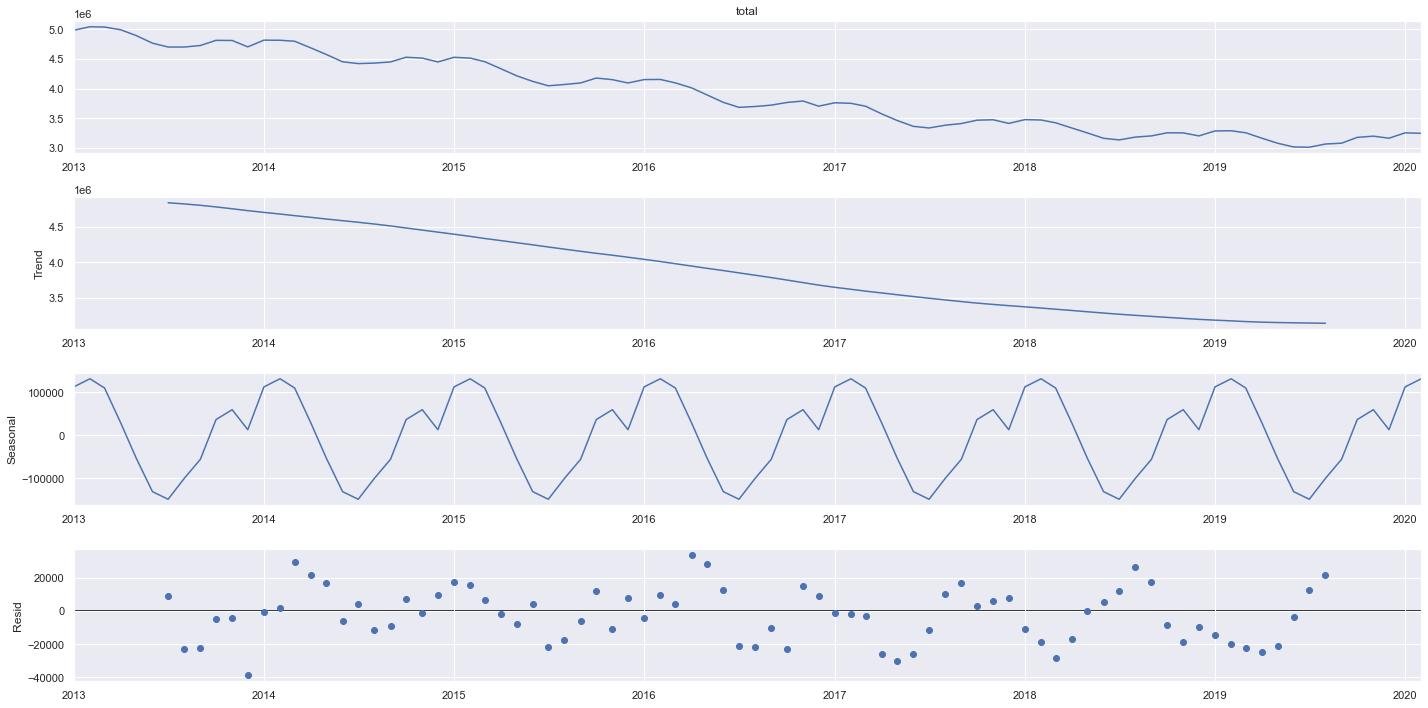

In [12]:
desglose=seasonal_decompose(df_paro_eda.total, 
                                   model='additive', 
                                   period=12)
desglose.plot()
plt.savefig('../pics/df_paro/decompose.png');

Analizando las gráficas ANTES del inicio de la pandemia, observamos:

- Que existe una **tendencia decreciente de desempleo**.
- Que el desempleo **es estacionario**.
- Hay **componente estacional**: los meses que **más se crea empleo se hallan en los meses de junio y julio** y también **en el mes de diciembre**.


## *4) Estimación mediante modelos*

### 4.1) Modelo de Suavizado Exponencial (ETS)

A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en el tiempo que ha habido desde el inicio de la pandemia, es decir, desde marzo del 2020. Como el dataset tiene datos hasta julio del 2022, hay 29 meses para el test_size.



Cantidad de períodos en Train: 86
Cantidad de períodos en Test: 29


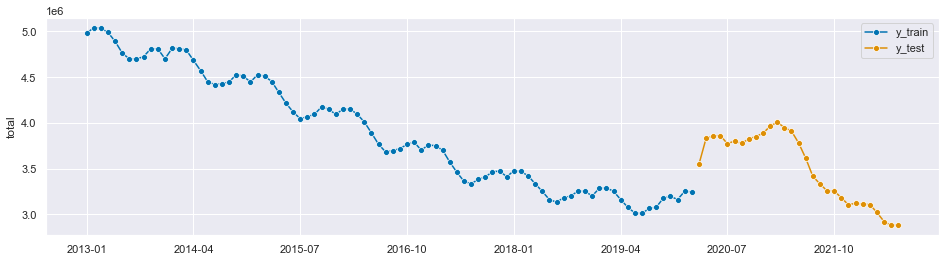

In [13]:
#Train-test
y_train_ets, y_test_ets = temporal_train_test_split(y = df_paro['total'].astype('float64').to_period('M'), 
               
                                            test_size=29)
#Grafico para representar la separación de los datos
plot_series(y_train_ets, y_test_ets, labels=["y_train", "y_test"])
print('Cantidad de períodos en Train:', y_train_ets.shape[0])
print('Cantidad de períodos en Test:', y_test_ets.shape[0])
plt.show();

Se realiza el pronóstico (forecasting) del horizonte temporal de 2 años. En sp, que es el número de periodos en un ciclo estacional completo, pondremos 12 para datos mensuales con ciclo anual:

In [68]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, y_test_ets.shape[0]+1)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
paro_auto_ets = AutoETS(auto=True, sp=12, n_jobs=-1)

paro_auto_ets.fit(y_train_ets)
paro_auto_ets.summary()

# Predicciones
paro_pred_ets = paro_auto_ets.predict(fh=list(fh))
paro_pred_ets.round().tail()

2022-03    3138857.0
2022-04    3075126.0
2022-05    3005904.0
2022-06    2938336.0
2022-07    2916927.0
Freq: M, dtype: float64

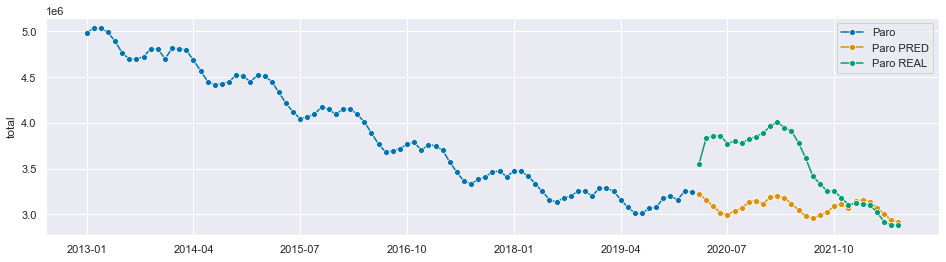

In [69]:
# Gráfica predicción
plot_series(y_train_ets, paro_pred_ets, y_test_ets, labels=["Paro", "Paro PRED", "Paro REAL"])
plt.show()

Se hace un zoom al gráfico:

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='total'>)

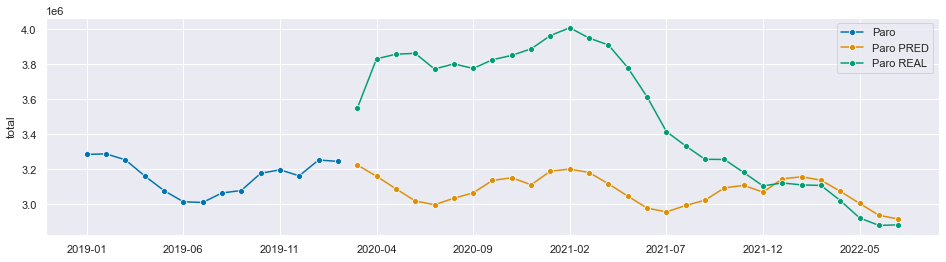

In [70]:
plot_series(y_train_ets["2019":],paro_pred_ets,y_test_ets,labels=["Paro", "Paro PRED", "Paro REAL"])

La predicción por ETS, a simple vista, no predice en absoluto el momento COVID, pero a partir de después del verano del 2021 sí que afina más su precisión. Vamos a calcular el error de las predicciones mediante el RMSE y MAPE. 

In [71]:
mse = MeanSquaredError(square_root=True)
mse_ets = mse(y_test_ets, paro_pred_ets)
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))

mape = MeanAbsolutePercentageError(symmetric=False)
mape_ets = mape(y_test_ets, paro_pred_ets)
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))

El modelo ETS genera un RMSE de: 555442.42
El modelo ETS genera un MAPE de: 12.08%


### 4.2) Modelo ARIMA

Al tratarse de una serie estacionaria, no habría que realizar ningún tipo de transformación a la serie para mejorar las predicciones con el método de estimación ARIMA.

Separamos el train y test a la serie transformada en logs:

86 29


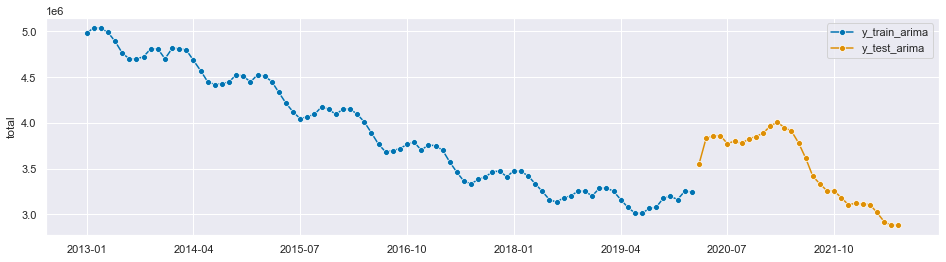

In [73]:
y_train_arima,y_test_arima=temporal_train_test_split(
    y=df_paro['total'].astype('float64').to_period('M').sort_index(),test_size=29)
plot_series(y_train_arima, y_test_arima, labels=["y_train_arima", "y_test_arima"])
print(y_train_arima.shape[0], y_test_arima.shape[0])
plt.show()

Generamos el modelo y se entrena con los datos del train:

In [74]:
fh = np.arange(1,y_test_arima.shape[0]+1)
paro_auto_arima=AutoARIMA(d=1,D=1,sp=12,suppress_warnings=True) # buscar para d=1 D=1 (SARIMAX (1,1,1))

paro_auto_arima.fit(y_train_arima)
paro_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   86
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -836.149
Date:                            Mon, 05 Sep 2022   AIC                           1678.299
Time:                                    18:19:06   BIC                           1685.170
Sample:                                         0   HQIC                          1681.037
                                             - 86                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0128      0.098      0.131      0.896      -0.179       0.204
ar.S.L12       0.0068      0.038      0.180      0.857      -0.068       0.081
sigma2      5.411e+08   4.49e-12    1.2e+20      0.000    5.41e+08    5.41e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.70   Prob(JB):                         0.34
Heteroskedasticity (H):               0.57   Skew:                            -0.20
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.14e+35. Standard errors may be unstable.
"""

In [75]:
paro_pred_arima = paro_auto_arima.predict(fh)
paro_pred_arima.round()

2020-03    3212042.0
2020-04    3120489.0
2020-05    3036412.0
2020-06    2972786.0
2020-07    2968689.0
2020-08    3023110.0
2020-09    3036973.0
2020-10    3135233.0
2020-11    3155911.0
2020-12    3121441.0
2021-01    3211736.0
2021-02    3203854.0
2021-03    3169849.0
2021-04    3078296.0
2021-05    2994219.0
2021-06    2930594.0
2021-07    2926498.0
2021-08    2980919.0
2021-09    2994781.0
2021-10    3093044.0
2021-11    3113723.0
2021-12    3079254.0
2022-01    3169549.0
2022-02    3161666.0
2022-03    3127661.0
2022-04    3036108.0
2022-05    2952031.0
2022-06    2888406.0
2022-07    2884310.0
Freq: M, dtype: float64

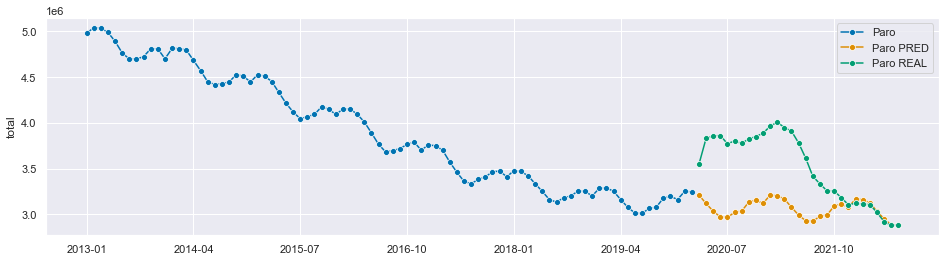

In [76]:
# representamos la serie predictiva
plot_series(y_train_arima, paro_pred_arima, y_test_arima, labels=["Paro", "Paro PRED", "Paro REAL"])
plt.show()

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='total'>)

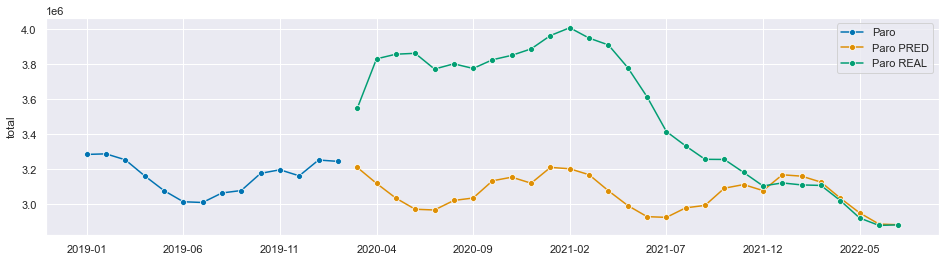

In [77]:
plot_series(y_train_arima['2019':],paro_pred_arima,y_test_arima,
            labels=["Paro","Paro PRED","Paro REAL"])

In [78]:
mse = MeanSquaredError(square_root=True)
mse_arima = mse(y_test_arima, paro_pred_arima)
print('El modelo ARIMA genera un RMSE de:', round(mse_arima,2))

mape = MeanAbsolutePercentageError(symmetric=False)
mape_arima = mape(y_test_arima, paro_pred_arima)
print('El modelo ARIMA genera un MAPE de: {}%'.format(round(mape_arima*100,2)))

El modelo ARIMA genera un RMSE de: 572652.72
El modelo ARIMA genera un MAPE de: 12.27%


#### Una comparativa entre ETS y ARIMA

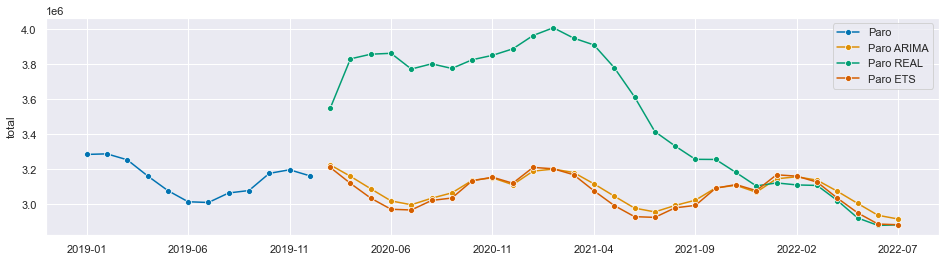

In [79]:
plot_series(y_train_arima["2019"], paro_pred_ets, y_test_arima, paro_pred_arima, 
            labels=["Paro", "Paro ARIMA", "Paro REAL", 'Paro ETS'])
plt.show()
# plt.savefig(../pics/df_paro/etsarima.png)

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [80]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_arima,2))

print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_arima*100,2)))

El modelo ETS genera un RMSE de: 555442.42
El modelo ARIMA genera un RMSE de: 572652.72
El modelo ETS genera un MAPE de: 12.08%
El modelo ARIMA genera un MAPE de 12.27%


Confirmamos que el modelo ETS, para este caso concreto, predice algo mejor ya que su error es menor.

### 4.3) Prophet

FB Prophet es un modelo muy extendido para la predicción de series temporales desarrollado por Facebook. El objetivo de este paquete es dar a los usuarios una herramienta potente y de fácil uso para predecir resultados de distintas series temporales. Este modelo alcanza sus mejores resultados con series estacionarias o series con una tendencia y estacionalidad marcadas, como es el caso del turismo en España. Suele ser peor cuando aumenta la aleatoria de la muestra. 

Dentro de nuestro DataFrame cambiamos el nombre de la columna temporal *'Periodo'* y la de la variable objetivo *'Total'* por *'ds'* e *'y'*, y también quitamos el Periodo como índice, pues todos estos cambios son necesarios para que el modelo funcione bien.

In [82]:
prophet_train = df_paro.reset_index() #cambiamos de índice
prophet_train.columns = ['ds', 'y'] #renombramos las columnas

In [83]:
prophet_y_train = y_train_ets.copy()
prophet_y_train = prophet_y_train.rename_axis('index').reset_index()
prophet_y_train.columns = ['ds', 'y']
prophet_y_train['ds'] = prophet_y_train['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_train)

86

In [86]:
prophet_y_test = y_test_ets.copy()
prophet_y_test = prophet_y_test.rename_axis('index').reset_index()
prophet_y_test.columns = ['ds', 'y']
prophet_y_test['ds'] = prophet_y_test['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_test)

29

18:20:54 - cmdstanpy - INFO - Chain [1] start processing
18:20:54 - cmdstanpy - INFO - Chain [1] done processing


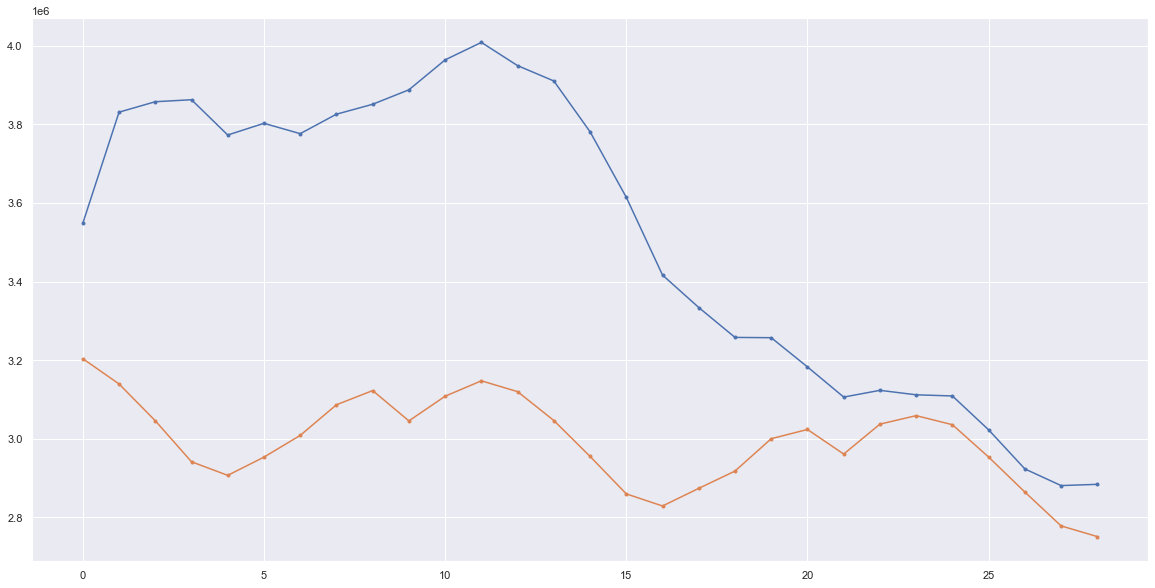

In [87]:
m = Prophet()
m.fit(prophet_y_train)

m_pred = m.make_future_dataframe(periods=len(prophet_y_test), freq='M')
prophet_forecast = m.predict(m_pred)

plt.plot(list(prophet_y_test['y']), '.-')
plt.plot(list(prophet_forecast.loc[86:, 'yhat']), '.-', label='Predicition')
plt.show()
# plt.savefig('../pics/df_paro/prophet.png')

In [88]:
# Forecast Accuracy
# MAPE
mape = MeanAbsolutePercentageError(symmetric=False)
mape_prophet = mape(prophet_y_test['y'], prophet_forecast.loc[86:, 'yhat'])
print('El modelo Prophet genera un MAPE de: {}%'.format(round(mape_prophet*100,2)))

#Mean Squared Error
mse = MeanSquaredError(square_root=True)
mse_prophet = mse(prophet_y_test['y'],prophet_forecast.loc[86:, 'yhat'])
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo Prophet genera un MAPE de: 13.98%
El modelo Prophet genera un RMSE de: 614759.29


In [89]:
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
110,2022-03-31,3035549.0,2925628.0,3152994.0
111,2022-04-30,2953188.0,2838713.0,3081528.0
112,2022-05-31,2864106.0,2733759.0,2997001.0
113,2022-06-30,2777961.0,2645497.0,2917673.0
114,2022-07-31,2750752.0,2607913.0,2901921.0


### 4.4) Comparativa errores y elección del mejor modelo

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [90]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_arima,2))
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo ETS genera un RMSE de: 555442.42
El modelo ARIMA genera un RMSE de: 572652.72
El modelo Prophet genera un RMSE de: 614759.29


2) MAPE (Error porcentual)

In [91]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_arima*100,2)))
print('El modelo Prophet genera un MAPE de {}%'.format(round(mape_prophet*100,2)))

El modelo ETS genera un MAPE de: 12.08%
El modelo ARIMA genera un MAPE de 12.27%
El modelo Prophet genera un MAPE de 13.98%


Confirmamos que **el mejor modelo para la predicción de esta serie temporal es la ETS**, ya que es el que mejor se ajusta a los datos reales y es el que menor error da, aunque se considera que es un error un poco elevado.

## *5) Predicción hasta finales de año*

A continuación realizamos la predicción de la serie temporal del desempleo hasta finales de año, es decir, hasta diciembre del 2022. 

In [92]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, 6)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
autoets_predict = AutoETS(auto=True, sp=12, n_jobs=-1)
y = df_paro.astype('float64').to_period('M')
autoets_predict.fit(y)

# Resumen 
autoets_predict.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:                      ETS(MAdM)   Log Likelihood               -1405.641
Date:                Mon, 05 Sep 2022   AIC                           2849.283
Time:                        18:21:18   BIC                           2901.436
Sample:                    01-31-2013   HQIC                          2870.451
                         - 07-31-2022   Scale                            0.000
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.262      3.816      0.000       0.486       1.513
smoothing_trend         0.8326      0.526      1.582      0.114      -0.199       1.864
smoothing_seasonal   6.682e-05        nan        nan        nan         nan         nan
damping_trend           0.8000      0.149      5.365      0.000       0.508       1.092
initial_level        4.869e+06   3.39e-08   1.44e+14      0.000    4.87e+06    4.87e+06
initial_trend       -2.344e+04   9.77e-07   -2.4e+10      0.000   -2.34e+04   -2.34e+04
initial_seasonal.0      0.9779      0.011     86.179      0.000       0.956       1.000
initial_seasonal.1      0.9883      0.013     77.788      0.000       0.963       1.013
initial_seasonal.2      0.9851      0.014     69.137      0.000       0.957       1.013
initial_seasonal.3      0.9646      0.015     63.630      0.000       0.935       0.994
initial_seasonal.4      0.9582      0.016     61.031      0.000       0.927       0.989
initial_seasonal.5      0.9483      0.016     59.704      0.000       0.917       0.979
initial_seasonal.6      0.9590      0.016     60.231      0.000       0.928       0.990
initial_seasonal.7      0.9784      0.016     62.573      0.000       0.948       1.009
initial_seasonal.8      0.9982      0.015     67.016      0.000       0.969       1.027
initial_seasonal.9      1.0075      0.013     78.541      0.000       0.982       1.033
initial_seasonal.10     1.0032      0.012     82.817      0.000       0.979       1.027
initial_seasonal.11     1.0000      0.011     88.326      0.000       0.978       1.022
===================================================================================
Ljung-Box (Q):                       20.31   Jarque-Bera (JB):              2171.32
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               7.49   Skew:                             2.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 2.03e+21. Standard errors may be unstable.
"""

In [93]:
# Predicción del desempleo para los próximos 6 meses:
paronew_pred = autoets_predict.predict(fh=list(fh))
paronew_pred.round()

,total
2022-08,2938509.0
2022-09,2978050.0
2022-10,3057595.0
2022-11,3080355.0
2022-12,3058160.0


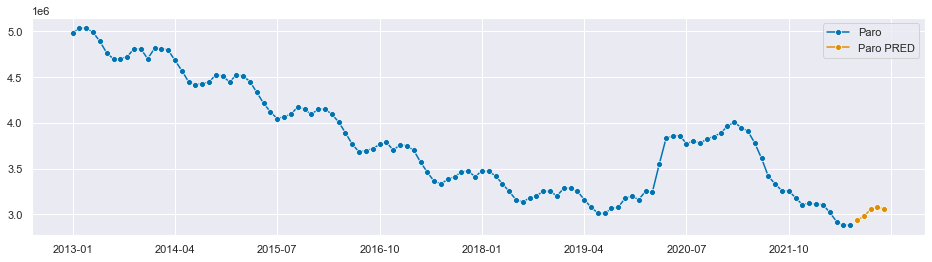

In [94]:
# Representamos gráficamente:
plot_series(y, paronew_pred, labels=["Paro", "Paro PRED"])
plt.show()
# plt.savefig('../pics/df_paro/predict2022.png')

In [96]:
# Guardado de la predicción en fichero
paronew_pred.to_csv('../predictions/paro.csv')

A continuación, en el Notebook "df_paro_new" realizaremos una intervención quitando el momento COVID-19 para comprobar cuánta de diferencia hay en la precisión de la predicción cuando no hay un momento atípico.